In [1]:
import os
import numpy as np
from shapely.geometry import Polygon, Point
import geopandas as gpd

os.chdir('/home/shirobakaidou/docker_lab/morph_index/test/')
os.getcwd()

'/home/shirobakaidou/docker_lab/morph_index/test'

In [2]:
# Define Input Path
inpath = os.path.join(os.getcwd(), 'input')

# Define Output Path
outpath = os.path.join(os.getcwd(), 'output')

# Input DEM
dem_input = 'hydrosheds_90m.tif'

# Input Basin
basin_input = 'Hydrosheds_level8_centralVN.shp'

# Define target CRS: WGS 84 / UTM zone 48N
dst_crs = 'EPSG:32648'

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
2


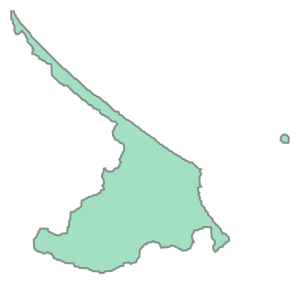

In [94]:
path_basin = os.path.join(outpath, 'Hydrosheds_level8_centralVN_index', 'Hydrosheds_level8_centralVN_index.shp')
basin = gpd.read_file(path_basin)

# Reproject
basin = basin.to_crs(dst_crs)
#basin.crs = dst_crs
basin_geom = basin['geometry']

print(type(basin))
print(type(basin_geom))
print(type(basin_geom[0]))
print(type(basin_geom[1][1]))
print(len(basin_geom[1]))
basin_geom[1]#[0]
#print(type(basin2['geometry'][0][0]))

In [6]:
# Outlets of all basins
outlet_e = np.array(basin['outlet_eas'])
outlet_n = np.array(basin['outlet_nor'])

In [96]:
#type(basin_geom[0]) == 'shapely.geometry.polygon.Polygon'
type(basin_geom[1]) == 'shapely.geometry.multipolygon.MultiPolygon'

False

In [97]:
# Set empty array in same length as 'basin' for basin_length.
basin_length_arr = np.empty(len(basin), dtype=float)
for i in range(len(basin)):
    
    # Create 'GeoSeries' of outlet coords
    outlet = gpd.GeoSeries([Point(float(outlet_e[i]), float(outlet_n[i]))])
    outlet.crs = 32648

    # Get x, y coords of points consisting basin polygon
    # Under the case where basin[geometry] is 'Polygon'
    if type(basin_geom[i]) == 'shapely.geometry.polygon.Polygon':
        x,y = basin_geom[i].exterior.coords.xy 
        
    # Under the case where basin[geometry] is 'Multipolygon',
    # since function 'v.exterior.coords.xy' doesn't apply on 'Multipolygon'
    elif type(basin_geom[i]) == 'shapely.geometry.multipolygon.MultiPolygon':
        #x,y = basin_geom[i][0].exterior.coords.xy
        
        # In order to find out the largest piece of the Multipolygons,
        # Set empty array in same length as the 'Multipolygon' for length of each polygon piece
        polyLen = np.empty(len(basin_geom[i]), dtype=float)
        for k in range(len(basin_geom[i])):
            # Calc x,y coords of points consisting each piece polygon 
            x,y = basin_geom[i][k].exterior.coords.xy
            # Let the number of polygon-consisting points represent the size of the polygon piece.
            polyLen[k] = len(x)
        # Get the index of the largest polygon piece in the 'Multipolygon'
        target_index = [k for k,w in enumerate(polyLen) if w==max(polyLen)]
        # Calc the x,y coords of the points consisting the largest piece Polygon
        x,y = basin_geom[i][target_index[0]].exterior.coords.xy
    
    # Create 'Geoseries' of the coords
    edge_points = gpd.GeoSeries([Point(x[j], y[j]) for j in range(len(x))])

    # Calc distances between 'outlet' and each 'polygon-consisting point',
    distance_arr = np.array([outlet.distance(w) for w in edge_points])

    # Get the maximal distance (in km), take it as 'Basin Length'
    basin_length = max(distance_arr)/1000
    
    # Accumulate all "Basin Lengths" in an array
    basin_length_arr[i] = basin_length
    
basin_length_arr

array([ 83.98709076,  89.03387538,  81.59095449, 146.28615359,
       145.04282723, 147.60757402])